In [1]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [2]:
data = pd.read_csv("C:/Users/AustonL/Documents/Data/loans_full_schema.csv")

# Case Study #1

## Dataset Description
The data set consists of financial information related to customers that have used the Lending Club Platform to obtain loans. Such information includes the customer's employment status, annual income, track record of having paid loan installments on time, etc. 

Issues with this dataset that not information is complete, such as emp_length having NaN values, or inconsistent formatting, such as how homeownership is in all caps while verified income is capitalized only on the first letters or how months_since_last_credit_inquiry consists of floats when the data within the column is effectively all integers.

## Visualization #1

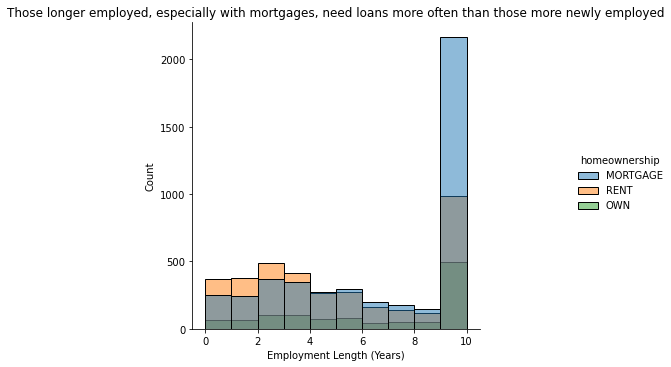

In [3]:
plot = sns.displot(data.dropna(axis = 0, subset = ["emp_length"]), x = "emp_length", binwidth = 1, hue = "homeownership")
plot.set(title = "Those longer employed, especially with mortgages, need loans more often than those more newly employed", xlabel="Employment Length (Years)")

### Observations of Visualization #1
The vast amount of people with loans are those with an employment length of 10 years or more, which is surprising to me as I expected those with a shorter employment length to be more in need of loans. One possible reason for this may be that loans are only given to those who have proof of having been employed for a while. Another reason could be that those with 10+ years of employment are now settling down and now want a house but are unable to afford it, so they take on loans (as shown by how homeownership drastically shifts to MORTGAGE in the plot when year 10 is reached).


## Visualization #2

[Text(0.5, 1.0, 'Those who request lower loans receive higher loan grades'),
 Text(0.5, 0, 'Loan Grade'),
 Text(0, 0.5, 'Loan Amount ($)')]

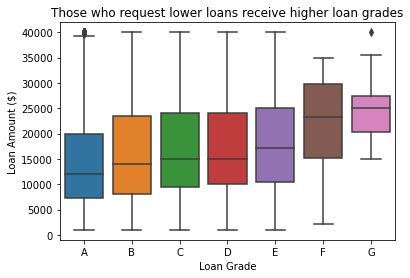

In [4]:
order = ["A", "B", "C", "D", "E", "F", "G"]
plot = sns.boxplot(data = data, x = "grade", y = "loan_amount", order = order)
plot.set(title = "Those who request lower loans receive higher loan grades", xlabel = "Loan Grade", ylabel = "Loan Amount ($)")

### Observations of Visualization #2

THe main takeaway from this plot is that the lower the loan that customer requests, the higher the grade the loan will be. With A being the highest grade, we can see that it is left skewed, showing that there is a higher proportion of people askng for a smaller loan than the mean loan amount in grade A. Compare this to grade D. While it is similarly left skewed, the median of loan amount is higher than that of grade A. This pattern follows as we go down the grade scale.

## Visualization #3

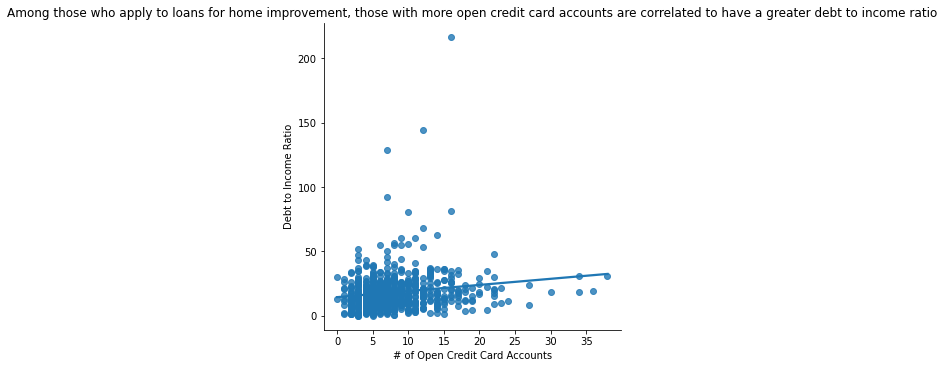

In [5]:
home_imprv = data[data["loan_purpose"] == "home_improvement"]
sns.lmplot(data = home_imprv, x = "num_open_cc_accounts", y = "debt_to_income", ci=False).set(title = "Among those who apply to loans for home improvement, those with more open credit card accounts are correlated to have a greater debt to income ratio", xlabel = "# of Open Credit Card Accounts", ylabel = "Debt to Income Ratio")

### Observations of Visualization #3

From the above plot, we can see that there is a positive correlation between how many credit cards a customer has open and what the customer's debt to income ratio is for those who apply to loans for home improvement. One possible reason for this may be that there are benefits that one may receive in opening a new credit line, in addition to any rewards plan that the line may have. This may have its drawbacks in that one must still pay all of them off. With so many, it becomes difficult to maintain, causing the individual to sink further into debt.

## Visualization #4

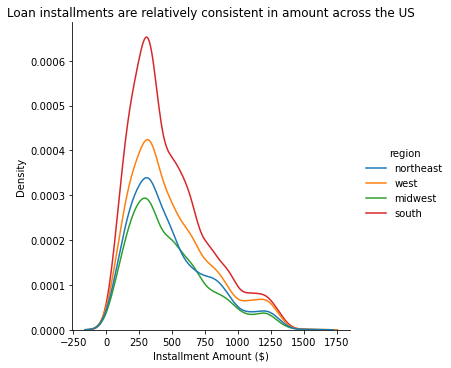

In [6]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM', 'HI', 'AK']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME', 'DC']

states = pd.DataFrame([west,midwest,south,northeast],index=['west','midwest','south','northeast'])
states = states.reset_index().melt('index')
data['region'] = data['state'].map(dict(zip(states['value'], states['index'])))
sns.displot(data, x = "installment", hue = "region", kind = "kde").set(title = "Loan installments are relatively consistent in amount across the US", xlabel = "Installment Amount ($)")

### Observations of Visualization #4

From the above plot, we can see that the distributions of the amount a customer has to pay for installments is relatively consistent across the 4 major regions of the US. This is surprising to me since the cost of living varies across the US, such as hotspots like New York or California being extra expensive while more midwestern regions being cheaper, so the loans not being proportional to the cost of living is interesting. One thing to note is that the density of loans is higher in the south, though one reason for this may simply be that there are more states considered to be in the south than other regions.

## Visualization #5

[Text(0.5, 1.0, 'Those who apply for joint loans will receive similar interest rates those who apply for individual loans'),
 Text(0.5, 0, 'Application Type'),
 Text(0, 0.5, 'Interest Rate')]

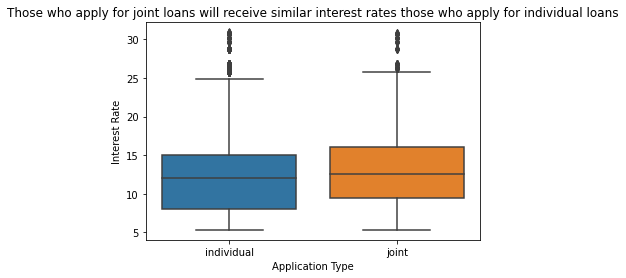

In [7]:
sns.boxplot(data = data, x = "application_type", y = "interest_rate").set(title = "Those who apply for joint loans will receive similar interest rates those who apply for individual loans", xlabel = "Application Type", ylabel = "Interest Rate")

### Observations of Visualization #5

From the above plot, we can see that the distributions of interest rates between those who apply for individual loans and those who apply for joint loans are relatively similar to each other. Such an observation is surprising to me as I expected those with joint loans to have a lower interest rate, given that those who would apply to joint are presumably in a family, thus, meaning there are at least two adults who can financially provide for and pay off the loan, so interest rate would not have to be as high due to increased likelihood of the loan being paid off.

## Predicting Interest Rate

The 2 algorithms I will be using are lasso regression and neural network multi-layer perceptron regression. I will combine them into one model by giving the lasso regression 20% weight and giving the MLP regression 80% weight. The feature set will be all the columns in the dataset, where data cleansing is performed by removing all the NaN values in numerical columns and by performing one-hot encoding on all non-numerical columns.

In [8]:
y = data["interest_rate"]
one_hot_encode = pd.get_dummies(data[['homeownership', 'verified_income', "loan_purpose", "application_type", "grade", "sub_grade", "loan_status", "initial_listing_status", "disbursement_method", "region"]])
num_only = data.select_dtypes(['number'])
dropped = num_only.drop(['annual_income_joint', 'debt_to_income_joint'], axis=1)
values = {"months_since_last_delinq" : data['months_since_last_delinq'].mean(), "months_since_90d_late" : data['months_since_90d_late'].mean(), "emp_length" : data['emp_length'].mean(), 
         "months_since_last_credit_inquiry" : data["months_since_last_credit_inquiry"].mean(), "num_accounts_120d_past_due": data["num_accounts_120d_past_due"].mean(),
         }
dropped = dropped.dropna(axis = 1)
X = pd.concat([dropped, one_hot_encode], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
scaler = StandardScaler().fit(X_train[dropped.columns])
X_train[dropped.columns] = scaler.transform(X_train[dropped.columns])
X_test[dropped.columns] = scaler.transform(X_test[dropped.columns])
lmodel = Lasso(alpha = 1)
lmodel.fit(X_train, y_train)
nmodel = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
model = lambda x: lmodel.predict(x) * 0.2 + nmodel.predict(x) * 0.8
results_train = model(X_train)
results_test = model(X_test)
error_train = abs(y_train - results_train)
error_test = abs(y_test - results_test)

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Visualized Results of Model

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of Absolute Error of Model on Training Set'),
 Text(0.5, 0, 'Absolute Error')]

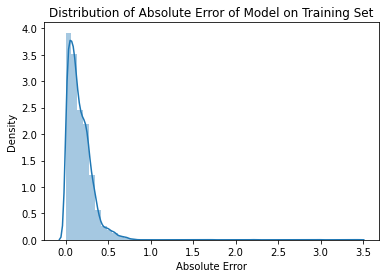

In [9]:
sns.distplot(error_train).set(title = "Distribution of Absolute Error of Model on Training Set", xlabel = "Absolute Error")

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of Absolute Error of Model on Testing Set'),
 Text(0.5, 0, 'Absolute Error')]

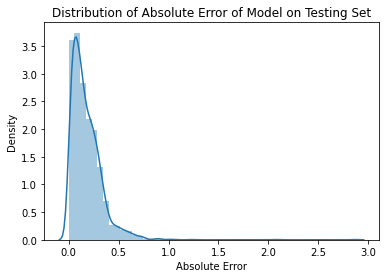

In [10]:
sns.distplot(error_test).set(title = "Distribution of Absolute Error of Model on Testing Set", xlabel = "Absolute Error")

### Discussion of Model
The model has been tested by performing a 70-30 training test split, with the plots above being the absolute error of my model from the testing set's values. As shown from the plots, the model is fairly accurate in that most of its error falls within a range of 1 from the actual interest rate in the testing set.

Enhancements that could have been made to this model if I had more time include removing outlier data points that were too skewed, being more careful about choosing the elements in my feature set instead of using all the features given to me, and giving the 2 algorithms proper weighting (instead of the 20-80 split I chose) that would be determined by careful analysis and additional data libraries.

Assumptions that were made by me include assuming that all features in the dataset are relevant to the model and that non-numerical values could be one-hot encoded (when it is possible that they should not have been in the first place).

My approach revolved around implementing algorithms that used regression, as regression displays the relationships between variables, and then linearly combining the two to achieve the best results.

# Case Study #2

In [66]:
df = pd.read_csv("C:/Users/AustonL/Documents/Data/casestudy.csv")

In [69]:
yr15 = df[df['year'] == 2015]
yr16 = df[df['year'] == 2016]
yr17 = df[df['year'] == 2017]

yr15existCust = yr15newCust = yr15['customer_email']
yr16newCust = set(yr16['customer_email']).difference(set(yr15['customer_email']))
yr16existCust = set(yr16['customer_email']).union(set(yr15['customer_email']))
yr17newCust = set(yr17['customer_email']).difference(set(yr16['customer_email']))
yr17existCust = set(yr17['customer_email']).union(set(yr16['customer_email']))

yr15newCustRev = yr15['net_revenue'].sum()
yr16newCustRev = yr16[yr16['customer_email'].isin(yr16newCust)]['net_revenue'].sum()
yr17newCustRev = yr17[yr17['customer_email'].isin(yr17newCust)]['net_revenue'].sum()

yr15existCustRev = yr15['net_revenue'].sum()
yr16existCustRev = yr16[yr16['customer_email'].isin(yr16existCust)]['net_revenue'].sum()
yr17existCustRev = yr17[yr17['customer_email'].isin(yr16existCust)]['net_revenue'].sum()

In [72]:
yrs = pd.DataFrame({"years":['2015', '2016', '2017'], "New Customer Revenue": [yr15newCustRev, yr16newCustRev, yr17newCustRev],
                      "Existing Customer Revenue Current Year" : [yr15existCustRev, yr16existCustRev, yr17existCustRev]})
yrs = yrs.set_index("years")
yrs

,New Customer Revenue,Existing Customer Revenue Current Year
years,,
2015,29036749.19,29036749.19
2016,18245491.01,25730943.59
2017,28776235.04,2740887.39


In [77]:
year15newcustomers = yr15existCust.to_frame()
year15newcustomers

,customer_email
0,nhknapwsbx@gmail.com
1,joiuzbvcpn@gmail.com
2,ukkjctepxt@gmail.com
3,gykatilzrt@gmail.com
4,mmsgsrtxah@gmail.com
...,...
231289,xtrpmgjbwp@gmail.com
231290,peeorxpsbr@gmail.com
231291,vanasezjpw@gmail.com
231292,dnpremlztb@gmail.com
